# 1. 长短期记忆网络LSTM

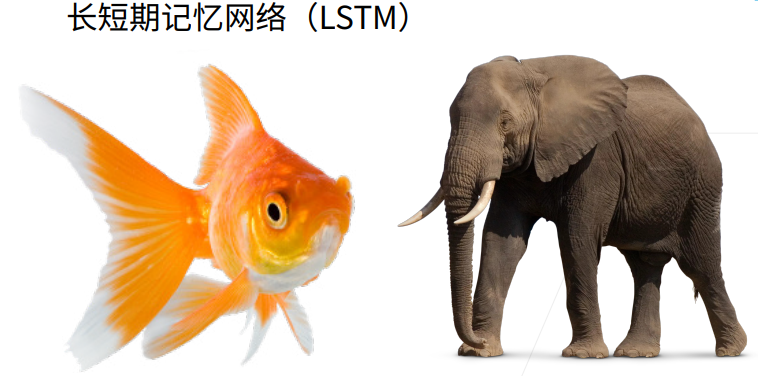

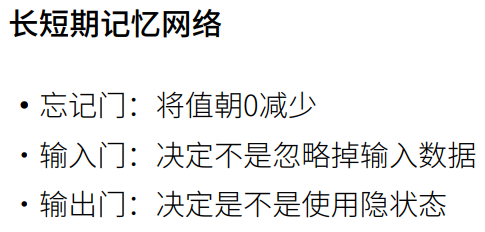

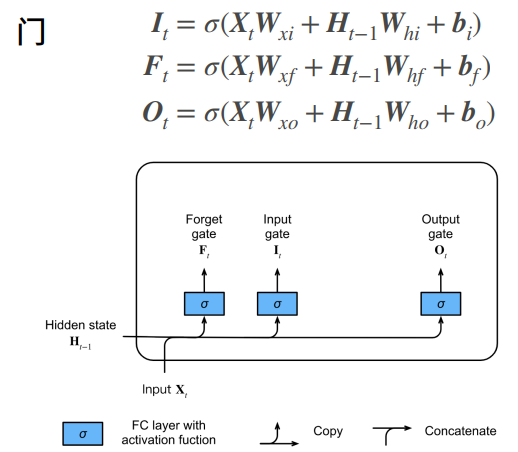

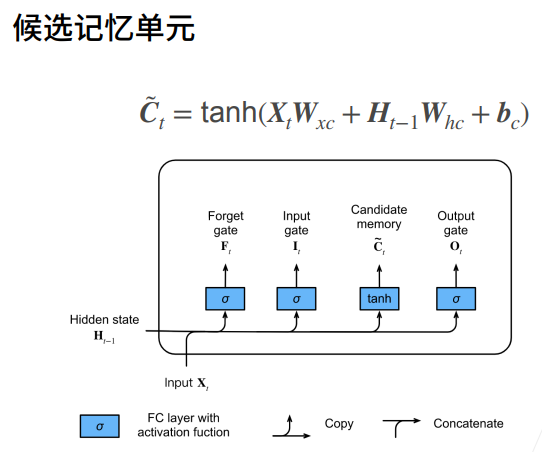

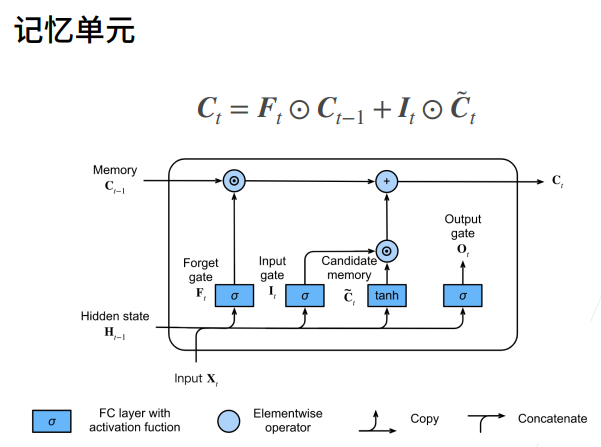

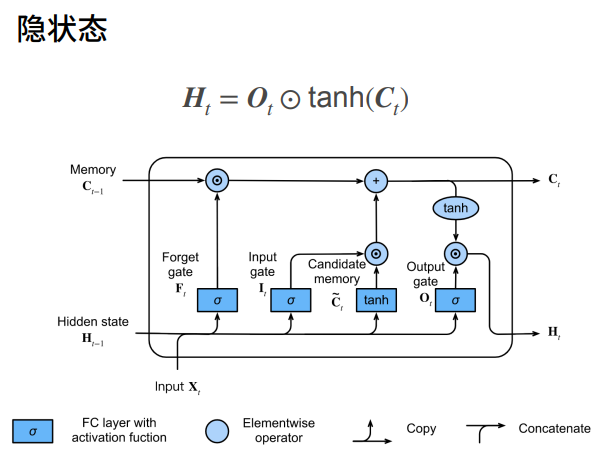

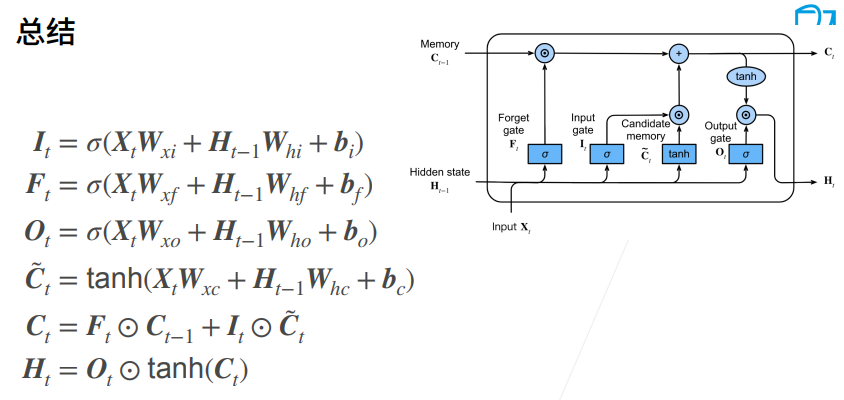

# 2. 长短期记忆网络LSTM

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

# 设置批量大小为32，时间步数为35
batch_size, num_steps = 32, 35
# 使用d2l库中的load_data_time_machine函数加载时间机器数据集，
# 并设置批量大小为32，时间步数为35，将加载的数据集赋值给train_iter和vocab变量
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

def get_lstm_params(vocab_size, num_hiddens, device):
    # 将词汇表大小赋值给num_inputs和num_outputs
    num_inputs = num_outputs = vocab_size
    
    # 定义一个辅助函数normal，用于生成具有特定形状的正态分布随机数，并将其初始化为较小的值
    def normal(shape):
        return torch.randn(size=shape, device=device) * 0.01
    
    # 定义一个辅助函数three，用于生成三个参数：输入到隐藏状态的权重矩阵、隐藏状态到隐藏状态的权重矩阵和隐藏状态的偏置项
    def three():
        return (normal(
            (num_inputs, num_hiddens)), normal((num_hiddens, num_hiddens)),
                torch.zeros(num_hiddens, device=device))
    
    # 调用three函数获取输入到隐藏状态的权重矩阵W_xi、隐藏状态到隐藏状态的权重矩阵W_hi和隐藏状态的偏置项b_i
    W_xi, W_hi, b_i = three()
    # 调用three函数获取输入到隐藏状态的权重矩阵W_xf、隐藏状态到隐藏状态的权重矩阵W_hf和隐藏状态的偏置项b_f
    W_xf, W_hf, b_f = three()
    # 调用three函数获取输入到隐藏状态的权重矩阵W_xo、隐藏状态到隐藏状态的权重矩阵W_ho和隐藏状态的偏置项b_o
    W_xo, W_ho, b_o = three()
    # 调用three函数获取输入到隐藏状态的权重矩阵W_xc、隐藏状态到隐藏状态的权重矩阵W_hc和隐藏状态的偏置项b_c
    W_xc, W_hc, b_c = three()
    # 生成隐藏状态到输出的权重矩阵W_hq
    W_hq = normal((num_hiddens, num_outputs))
    # 生成输出的偏置项b_q
    b_q  = torch.zeros(num_outputs, device=device)
    # 将所有参数组合成列表params
    params = [W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xo, W_ho, b_o, W_xc, W_hc, b_c, W_hq, b_q]    
    
    # 变量所有参数
    for param in params:
        # 将所有参数的requires_grad属性设置为True，表示需要计算梯度
        param.requires_grad_(True)
        
    # 返回所有参数
    return params

In [2]:
# 初始化函数
def init_lstm_state(batch_size, num_hiddens, device):
    # 返回一个元组，包含两个张量：一个全零张量表示初始的隐藏状态，和一个全零张量表示初始的记忆细胞状态。
    return (torch.zeros((batch_size, num_hiddens), device=device),
           torch.zeros((batch_size, num_hiddens),device=device))

In [3]:
# 实际模型
def lstm(inputs, state, params):
    # 解包参数列表params，分别赋值给对应的变量
    [W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xo, W_ho, b_o, W_xc, W_hc, b_c, W_hq, b_q] = params
    # 解包状态元组state，分别赋值给隐藏状态H和记忆细胞状态C
    (H, C) = state
    # 创建一个空列表用于存储每个时间步的输出
    outputs = []
    # 对于输入序列中的每个时间步
    for X in inputs:
        # 输入门的计算：使用输入、隐藏状态和偏置项，通过线性变换和sigmoid函数计算输入门
        I = torch.sigmoid((X @ W_xi) + (H @ W_hi) + b_i)
        # 遗忘门的计算：使用输入、隐藏状态和偏置项，通过线性变换和sigmoid函数计算遗忘门
        F = torch.sigmoid((X @ W_xf) + (H @ W_hf) + b_f)
        # 输出门的计算：使用输入、隐藏状态和偏置项，通过线性变换和sigmoid函数计算输出门
        O = torch.sigmoid((X @ W_xo) + (H @ W_ho) + b_o)
        # 新的记忆细胞候选值的计算：使用输入、隐藏状态和偏置项，通过线性变换和tanh函数计算新的记忆细胞候选值
        C_tilda = torch.tanh((X @ W_xc) + (H @ W_hc) + b_c)
        # 更新记忆细胞状态：将旧的记忆细胞状态与遗忘门和输入门的乘积相加，再与新的记忆细胞候选值的乘积相加，得到新的记忆细胞状态
        C = F * C + I * C_tilda
        # 更新隐藏状态：将输出门和经过tanh函数处理的记忆细胞状态的乘积作为新的隐藏状态
        H = O * torch.tanh(C)
        # 输出的计算：使用新的隐藏状态和偏置项，通过线性变换得到输出
        Y = (H @ W_hq) + b_q
        # 将当前时间步的输出添加到列表中
        outputs.append(Y)
    # 将所有时间步的输出在维度0上拼接起来，作为最终的输出结果；
    # 返回最终的输出结果和更新后的隐藏状态和记忆细胞状态的元组
    return torch.cat(outputs, dim=0), (H, C)

perplexity 1.1, 26271.0 tokens/sec on cuda:0
time travellerit s against reason said filby wo onles of the fil
traveller cursedwe can ghee was aloxmat eachanerurely but y


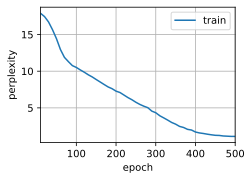

In [4]:
# 训练
# 获取词汇表大小，并设置隐藏单元数量为256，设备为GPU（如果可用）
vocab_size, num_hiddens, device = len(vocab), 256, d2l.try_gpu()
# 设置训练的轮数为500，学习率为1
num_epochs, lr = 500, 1
# 使用d2l库中的RNNModelScratch类创建一个基于LSTM的模型对象，
# 并传入词汇表大小、隐藏单元数量、设备、参数初始化函数、初始状态函数和LSTM模型函数
model = d2l.RNNModelScratch(len(vocab), num_hiddens, device, get_lstm_params, init_lstm_state, lstm)       
# 使用d2l库中的train_ch8函数进行模型的训练，传入模型对象、训练数据迭代器、词汇表、学习率、训练轮数和设备
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)

perplexity 1.0, 359354.8 tokens/sec on cuda:0
time travelleryou can show black is white by argument said filby
traveller with a slight accession ofcheerfulness really thi


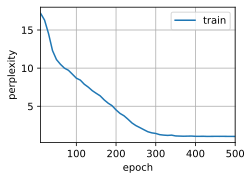

In [5]:
# 简洁实现
# 输入特征数量等于词汇表大小
num_inputs = vocab_size
# 使用nn.LSTM创建一个LSTM层，输入特征数量为num_inputs，隐藏单元数量为num_hiddens
lstm_layer = nn.LSTM(num_inputs, num_hiddens)
# 使用d2l库中的RNNModel类创建一个基于LSTM的模型对象，传入LSTM层和词汇表大小
model = d2l.RNNModel(lstm_layer, len(vocab))
# 将模型移动到指定的设备上
mode = model.to(device)
# 使用d2l库中的train_ch8函数进行模型的训练，传入模型对象、训练数据迭代器、词汇表、学习率、训练轮数和设备
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)